# Advances in Computing with Uncertainties &mdash; Lecture 4

* Instructor: Laura Lyman
* Date: 30 September 2021
* Fall Quarter, Stanford University

In [42]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Improve the quality of the figures
mpl.rcParams['figure.dpi'] = 300
import scipy.stats as st
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

## Objectives

+ to practice Monte Carlo (MC) integration estimates
+ to learn how such estimates are justified by the LLN
+ to qualitatively observe the epistemic uncertainty introduced by integrating via MC
+ to quantify the epistemic uncertainty in Monte Carlo estimates

## Integrating with Monte Carlo

Let $X$ be a real-valued random variable with **probability density** $p(x)$ and $f(X)$ be a function of $X$.
We would like to calculate the integral:
$$
\mathbb{E}\left[f(X)\right] := \int f(x)p(x)dx.
$$
assuming it exists (i.e. is finite).

Later, we will look at quadrature and numerical integration techniques for estimating $\mathbb{E}\left[f(X)\right]$ more efficiently. But for now, let's observe what Monte Carlo can offer.

For background, let's recall the strong version of the <a href="https://nbviewer.jupyter.org/github/lalyman/cme-270/blob/main/lecture-notes/lecture3_sept28/lecture3-mc-examples.ipynb#LLN">Law of Large Numbers</a>. The theorem states that if you have a sequence of i.i.d. random variables $Y_1, Y_2,...$ with probability density $p(x)$ and $\mathbb{E}(Y) < \infty$, then

$$
\lim_{n \rightarrow \infty} \frac{1}{n}\sum_{j=1}^n Y_j = \mathbb{E}[Y],
$$
with probability one (i.e. almost surely). 

For any function $f$, the random variables $f(X_1), f(X_2),\ldots$ are i.i.d. if the $X_1, X_2, \ldots$ are i.i.d. Therefore, if $\mathbb{E}_X(f(X)) < \infty$, by taking $Y_j = f(X_j)$  for i.i.d. $X_1, X_2,\ldots$ with $\mathbb{E}(X) < \infty$,  we have that

$$ \lim_{n \rightarrow \infty} \frac{1}{n}\sum_{j=1}^n f(X_j) = \mathbb{E}[f(X)] $$
with probability one. 

Let's try it out with a function in 1D. Suppose $X\sim\mathcal{U}(0,1)$. Consider
$$
f(x) = \left(\cos(50x) + \sin(20x)\right)^2.
$$
The correct value for the expectation can be found analytically; it is
$$
\mathbb{E}[f(x)] = 0.965.
$$

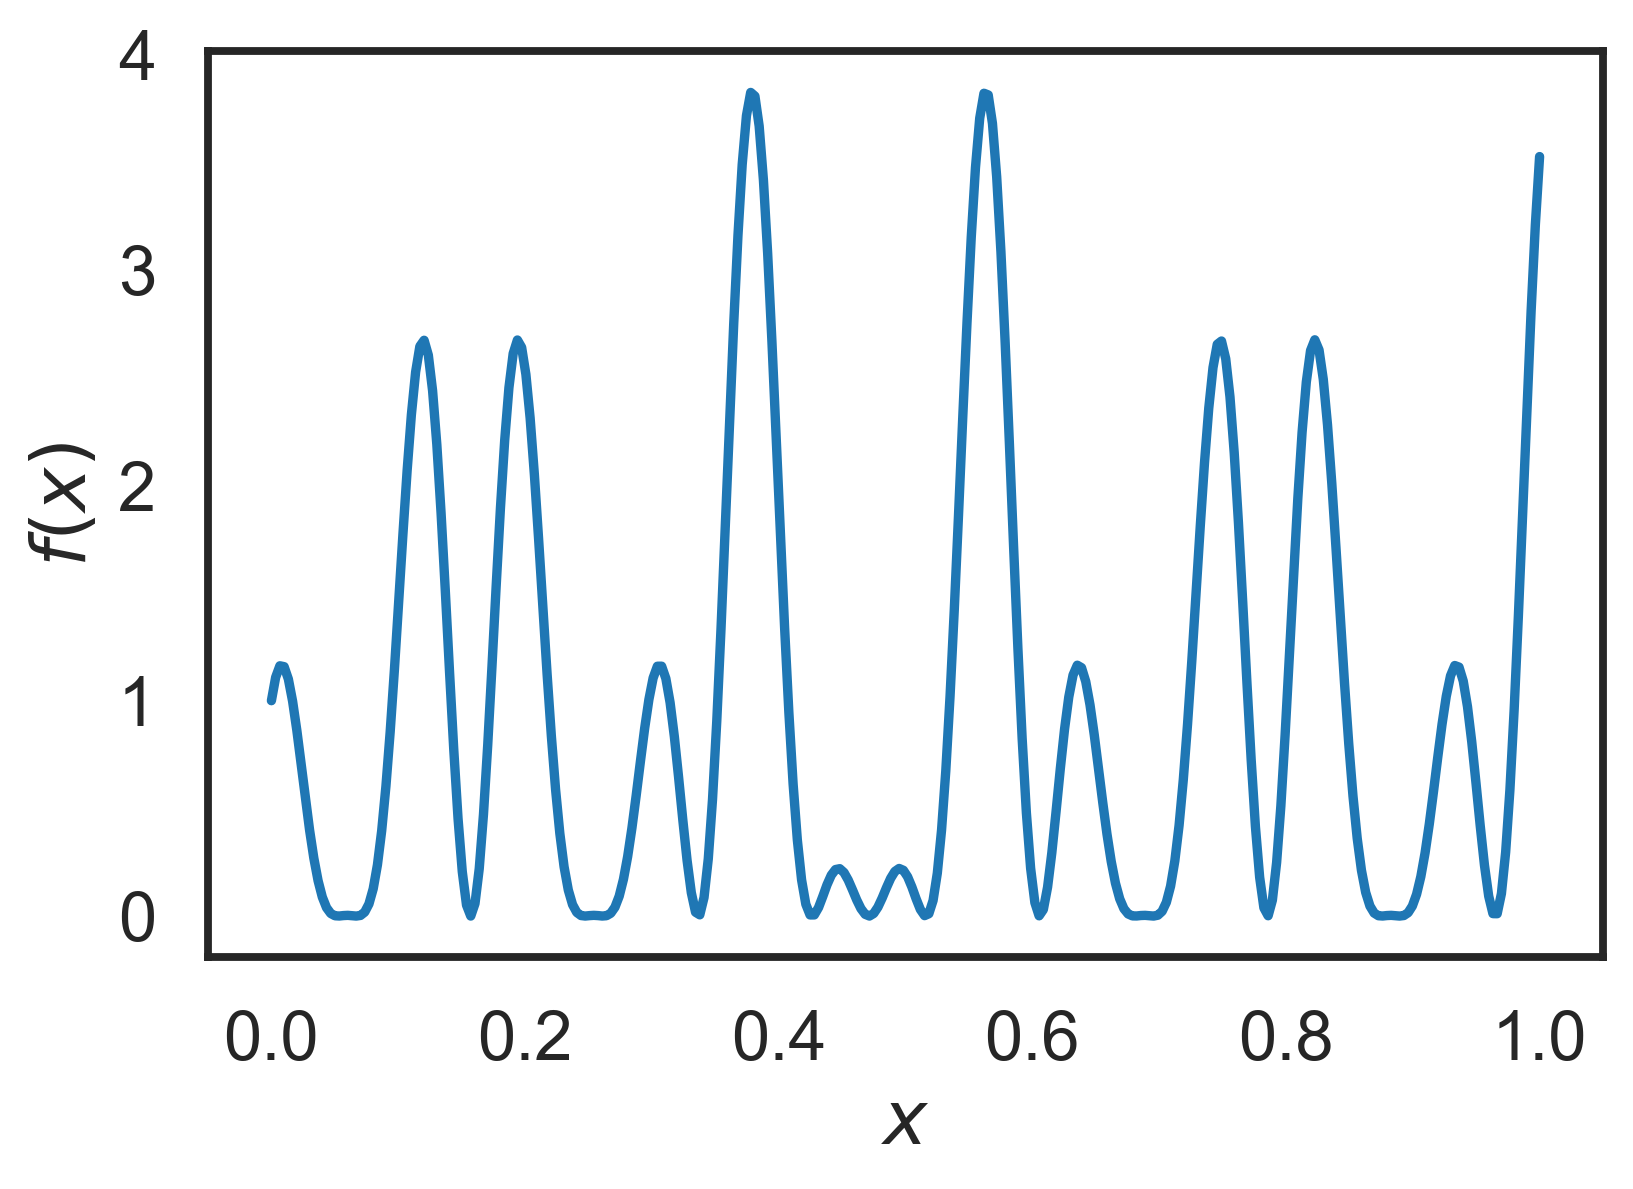

In [8]:
# Define the function
f = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2

# Visualize f(x)
fig, ax = plt.subplots()
x = np.linspace(0, 1, 300)
ax.plot(x, f(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$');

Okay, now we can use Monte Carlo to estimate the definite integral. That is,

\begin{alignat*}{2}
\int_{-\infty}^{\infty} f(x) p(x) dx &= \int_0^1 f(x) dx \qquad &&\text{[since $p(x) = 1$ on $[0,1)$ and is 0 everwhere else]} \\
&= \int_0^1 (\cos(50x) + \sin(20x))^2 dx \quad &&\text{[definition of $f$]}  \\
&\approx \frac{1}{n} \sum_{i=1}^n (\cos(50 \thinspace X_i) + \sin(20 \thinspace X_i))^2  \quad &&\text{[for i.i.d. $X_1, \ldots, X_n \sim U(0,1)$]}
\end{alignat*}
when $n$ is large. We can write a helper function for this procedure.

In [9]:
# Estimate the 1D integral of a real-valued function f with respect to a probability density p.
# Other equivalent ways of saying this are to:
#     * approximate E_X(f)     (the expected value of f with respect to the random variable X)
#     * approximate the integral of the quantity [f(x)p(x)] over all real numbers x
#
# Of course, this function assumes that the requested integral/expected value exists
# (When people say fancy phrases like, "X is Lebesgue integerable w.r.t. the measure induced by a random 
# variable X," all they are saying is to assume the integral in question is not infinite.)
#
# The estimate of the integral is given by the sample mean with a large number of samples n, which is 
#      S_n(f) := 1/n * [f(X_i) summed from i = 1 to n].
def get_mc_estimate(max_n = 1000, func = f, sampler = np.random.rand):
    """
    Return the the MC estimate of the 1D integral of a user-defined f function.
    
    :param max_n:   Maximum number of sample
    :param func:    The function to integrate
    :param sampler: A function that samples the X_i;
                    the default is np.random.rand, which is the uniform distribution on [0,1)
    """
    S_n = np.ndarray((max_n,))  # Sample mean; an array with the running estimates of the expecation
    s = 0.                      # Variable to keep track of the sum
    for i in range(max_n):
        # Sample X_i
        X_i = sampler(1)
        # Update the sum
        s += f(X_i)
        # The current approximation of the integral is
        S_n[i] = s / (i + 1)
    return(S_n)

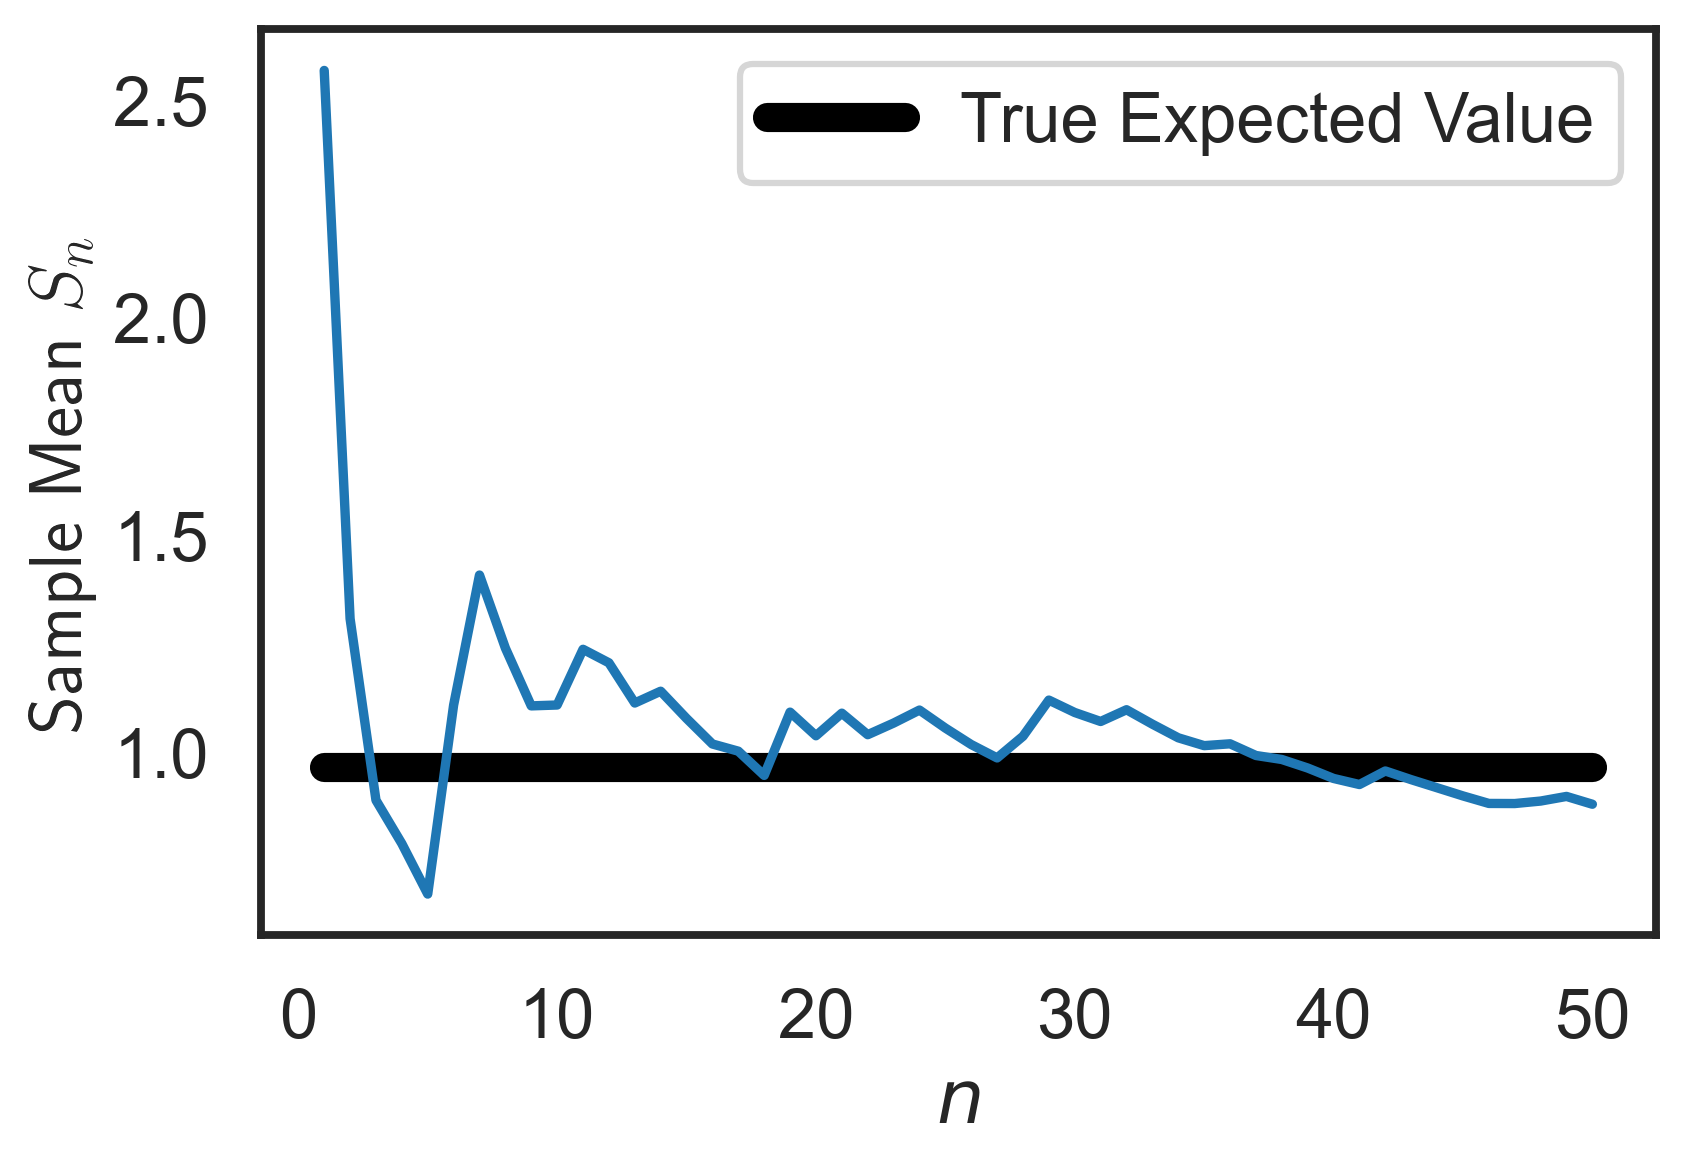

In [4]:
# Number of independent MC runs
num_mc = 1
# Maximum number of samples to take per MC run
max_n  = 50
fig, ax = plt.subplots()
# Plot the true expected value for reference
ax.plot(np.arange(1, max_n+1), [0.965] * max_n, color='black', linewidth=7.0)
for _ in range(num_mc):
    S_n_vals = get_mc_estimate(max_n = max_n, func = f)
    ax.plot(np.arange(1, max_n+1), S_n_vals)

ax.set_xlabel('$n$')
ax.set_ylabel('Sample Mean $S_n$', usetex = True);
ax.legend(['True Expected Value'])

### Exercises and Observations to Ponder

1. Run the code 2-3 times. Observe that every time you get a slightly different answer.
2. Set `num_mc` to 10. Notice how different Monte Carlo runs form an envelope around the true analytic answer (the black line).
3. Increase ``max_n`` until your get an estimate that seems close to the true answer. Try this for `num_mc` = 1 and `num_mc` = 10.

The differences in (1) and (2) come from *epistemic uncertainty*. While the values of a random variable are unknown, the output we are estimating, i.e. the expected value $\mathbb{E}_X(f(X)) = \int_0^1 f(x) dx$, is a *definite integral*. To emphasize, there is nothing "random" about the quantity of interest $\mathbb{E}_X(f(X))$; it is just some number (in this case $\approx 0.965$). Yet our approximation of it reflects the uncertainty in the $X_i$ "measurements" we are sampling. By the LLN, the effects of such uncertainty are mitigated by taking more measurements (samples), as shown in (3).


### Central Limit Theorem

Qualitatively, we can observe the effects of epistemic uncertainty. By the LLN, we know that for i.i.d. $X_1, \ldots, X_n$ with finite (common) expected value $\mu := \mathbb{E}(X)$, the sample mean $S_n$ converges to $\mu$ as $n \rightarrow \infty.$ 

The **Central Limit Theorem** (CLT) takes this a step further. The theorem states that if we *also* know that the $X_i$ have finite variance, then we can say what the **distribution** of the random variable $S_n$ looks like. That is, we have a sense of what values $S_n$ might take and their associated probabilities. In particular, given the same assumptions as those of the LLN, if 
$$ \sigma^2 := \mathbb{V}(X) = \int (x - \mu)^2 p(x) dx < \infty  \qquad [\text{where } p(x) \text{ is the PDF of } X],$$
then
$$ S_n:=\frac{1}{n}\sum_{j=1}^n X_j \overset{\mathcal{D}}{\rightarrow} \mathcal{N}\left(\mu, \sigma^2\right) $$
as $n \rightarrow \infty$. As a random variable, this means that $S_n$ starts to look like a Gaussian as $n$ becomes large. The $\overset{\mathcal{D}}{\rightarrow}$ means convergence in distribution. This is another type of way in which a random variable can converge to another random variable. (We saw convergence in **probability** and **almost sure convergence** <a href="https://nbviewer.jupyter.org/github/lalyman/cme-270/blob/main/lecture-notes/lecture3_sept28/lecture3-mc-examples.ipynb#LLN">here</a>). 

### Convergence in Distribution
Convergence in distribution is the weakest type of convergence, in the sense that

$$ \left[ \text{almost sure convergence }\left( \text{denoted} \overset{\text{a.s.}}{\longrightarrow} \text{ or } \overset{\text{w.p. 1}}{\longrightarrow}\right) \right] \Rightarrow \left[ \text{convergence in probability }\left( \text{denoted} \overset{\mathcal{P}}{\longrightarrow}\right) \right] \Rightarrow \left[ \text{convergence in distribution }\left( \text{denoted} \overset{\mathcal{D}}{\longrightarrow}\right) \right]. $$

In particular, we say that *any* sequence $X_1, X_2,...$ of real-valued random variables is said to **converge in distribution** (also called **converge weakly** or **converge in law**) to a random variable $X$ if

$$ \displaystyle \lim_{j\to \infty }F_{j}(x)=F(x) $$
where
 * $F_j: \mathbb{R} \rightarrow [0,1]$ is the cumulative distribution function (CDF) of the random variable $X_j$ (defined below),
 * $F: \mathbb{R} \rightarrow [0,1]$ is the CDF of $X$, and
 * the little $x \in \mathbb{R}$ is any point such that $F(x)$ is continuous at that point.
 
Now we review some definitions. The **cumulative distribution function (CDF)** $F$ of a real-valued (1D) random variable $X$ is the function
\begin{alignat*}{2} F :\mathbb{R} \rightarrow [0,1] \qquad F(x) &= \mathbb{P}(X \le x) \\
&= \int_{-\infty}^x p(s) ds \qquad &&\text{[if $F$ has a PDF $p$]} 
\end{alignat*}
Of course, for higher dimensional $X$ (e.g. a random vector with values in $\mathbb{R}^d$), the definition is simply changed so that the domain of $F$ is $\mathbb{R}^d$ and $X \le \vec{x}$ is interpreted componentwise.

**Example.** Let's test out this convergence in distribution for the $X_j$ are i.i.d. exponential random variables. Let's say their scale parameter $r = 5$, i.e. each $X_j \sim \text{Exp}(5).$ We will use `numpy.random.exponential` to sample from the exponential distribution with parameter 

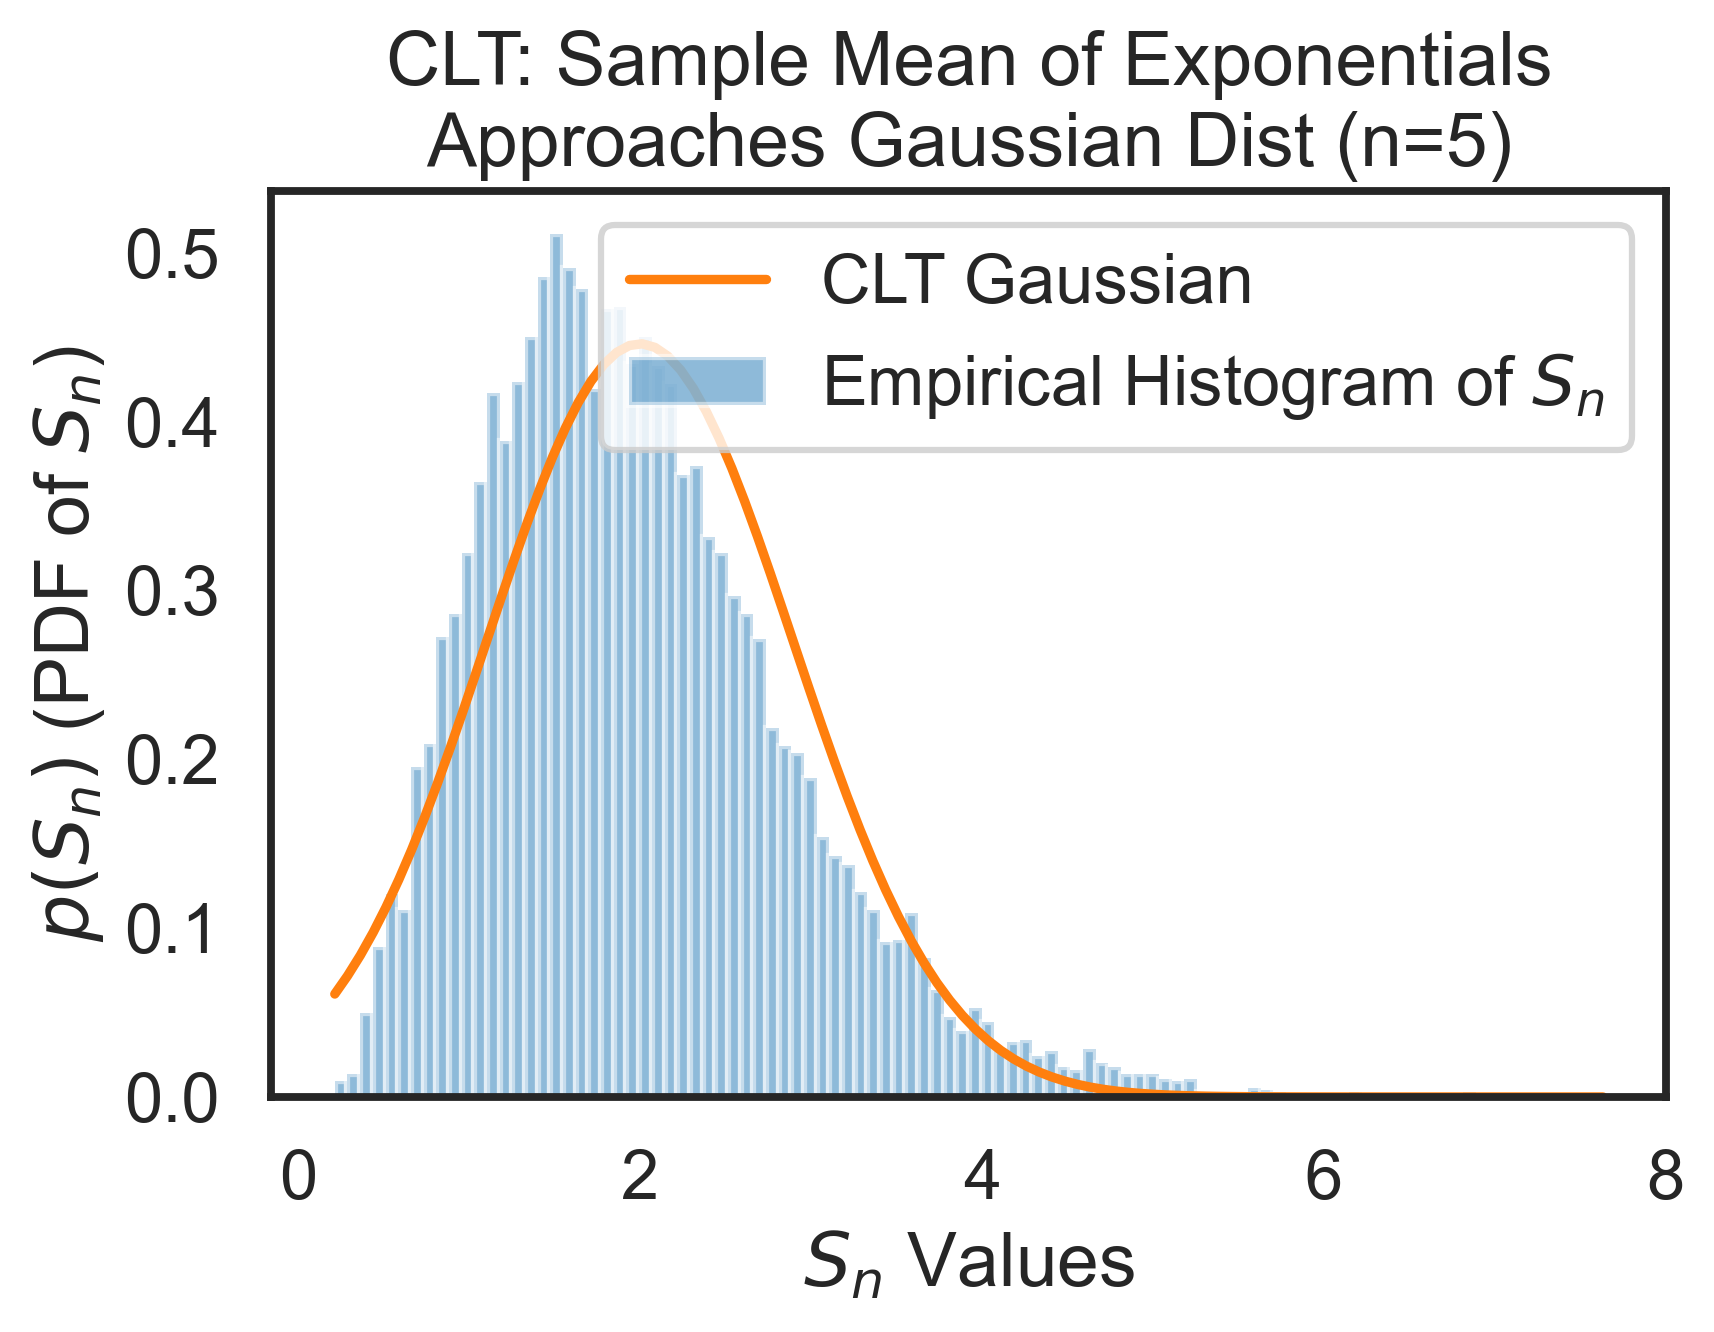

In [53]:
r = 0.5
N = 5   #  How many iid variables are we going to sum?
M = 10000 # How many times do you want to sample?
# Note that np.random.exponential uses the inverse of the rate
# 1/r as its input parameter 'scale'; always a good idea to double
# check that kind of documentation
Ts = np.random.exponential(scale=1./r, size=(N, M))  
# These are the samples of SN:
SN = np.sum(Ts, axis=0) / N  # Notice that I am only summing the rows

fig, ax = plt.subplots()
ax.hist(SN, bins=100, density = True, alpha=0.5, label='Empirical Histogram of $S_n$')
mu_CLT = 1. / r             # CLT mean
sigma_CLT = np.sqrt(1. / (N * r**2)) # CLT standard deviation
Ss = np.linspace(SN.min(), SN.max(), 100)
ax.plot(Ss, st.norm(loc=mu_CLT, scale=sigma_CLT).pdf(Ss), label='CLT Gaussian')
ax.set_xlabel('$S_n$ Values')
ax.set_ylabel('$p(S_n)$ (PDF of $S_n$)')
ax.set_title('CLT: Sample Mean of Exponentials\nApproaches Gaussian Dist (n=%d)' % N)
plt.legend(loc='best')

The $y$-axis is the PDF of $S_n$ evaluated at the different values $S_n$ took on the $x$-axis; i.e. the $``\mathbb{P}(S_n = x)"$ for a given $x$ on the $x$-axis. 

### Quantifying the Epistemic Uncertainty

Let's return to the original problem of integrating with Monte Carlo. We would like to estimate the integral $\mathbb{E}\left[f(X)\right] := \int f(x)p(x)dx $ (assuming it exists) for a given random variable $X$ with PDF $p(x).$ As before, let $Y_j = f(X_j)$ for i.i.d. $X_j$ with finite mean. Take note: $f$ is *any* function such that $\mathbb{E}_X(f(X))$ exists. Then the CLT gives us that

$$
S_n(f):=\frac{1}{n}\sum_{j=1}^n f(X_j) \overset{\mathcal{D}}{\rightarrow} \mathcal{N}\left(\mathbb{E}(f(X)), \frac{1}{n}\mathbb{V}(f(X))\right),
$$
in distribution as $n\rightarrow \infty$. The variance $\frac{1}{n}\mathbb{V}(f(X))$ comes from
$$ \mathbb{V}(S_n(f)) = \mathbb{V}(\frac{1}{n} \sum_{j=1}^n f(X_j) ) = \frac{1}{n^2} \sum_{j=1}^n \mathbb{V}(f(X_j)) = \frac{n \mathbb{V}(f(X))}{n^2} =  \frac{1}{n}\mathbb{V}(f(X)).$$

For a $\approx 95\%$ confidence interval, the true expectation will be within $2$ standard deviations of $S_n$  i.e.,
$$
\mu_f := \mathbb{E}(f(X)) = S_n(f) \pm \frac{2}{\sqrt{n}}\mathbb{V}(f(X)).
$$

Equivalently, 
$$S_n(f) = \mu_f \pm  \frac{2}{\sqrt{n}}\mathbb{V}(f(X))$$

This is perfect, except from the fact that we don't really know what $\mathbb{V}(f(X))$ is.
Well, let's approximate it also with MC!
Define the **sample variance** as
$$
V_n = \frac{1}{n}\sum_{j=1}^n\left(f(X_j) - \mu_f \right)^2.
$$
Then we can say that:
$$
\mu_f = S_n \pm \frac{2}{\sqrt{n}}\sqrt{V_n}.
$$
with 95% confidence. Let's see if this works.

In [12]:
# Let's modify the previous function so that it also returns the variance estimate
def get_mc_estimate(max_n =1000, func = f,  sampler = np.random.rand):
    """
    Return the the MC estimate of the 1D integral of a user-defined f function.
    
    :param max_n:   Maximum number of sample
    :param func:    The function to integrate
    :param sampler: A function that samples the X_i;
                    the default is np.random.rand, which is the uniform distribution on [0,1)
    """
    S_n = np.ndarray((max_n,))  # Sample mean; an array with the running estimates of the expecation
    V_n = np.ndarray((max_n,))  # Sample variance;  an array with the running estimates of Var(f(X))
    s  = 0.                     # Variable to keep track of the sum (for expected val)
    s2 = 0.                     # Variable to keep track of the sum (for var)
    for i in range(max_n):
        # Sample X_i
        X_i = sampler(1)
        # Update the sum
        s += f(X_i)
        # Current approx of the original integral (expected value)
        S_n[i] = s / (i + 1)
        s2 += (f(X_i) - S_n[i]) ** 2
        # The current approximation of the epistemic variance
        V_n[i] = s2 / (i + 1)
    return(S_n, V_n)

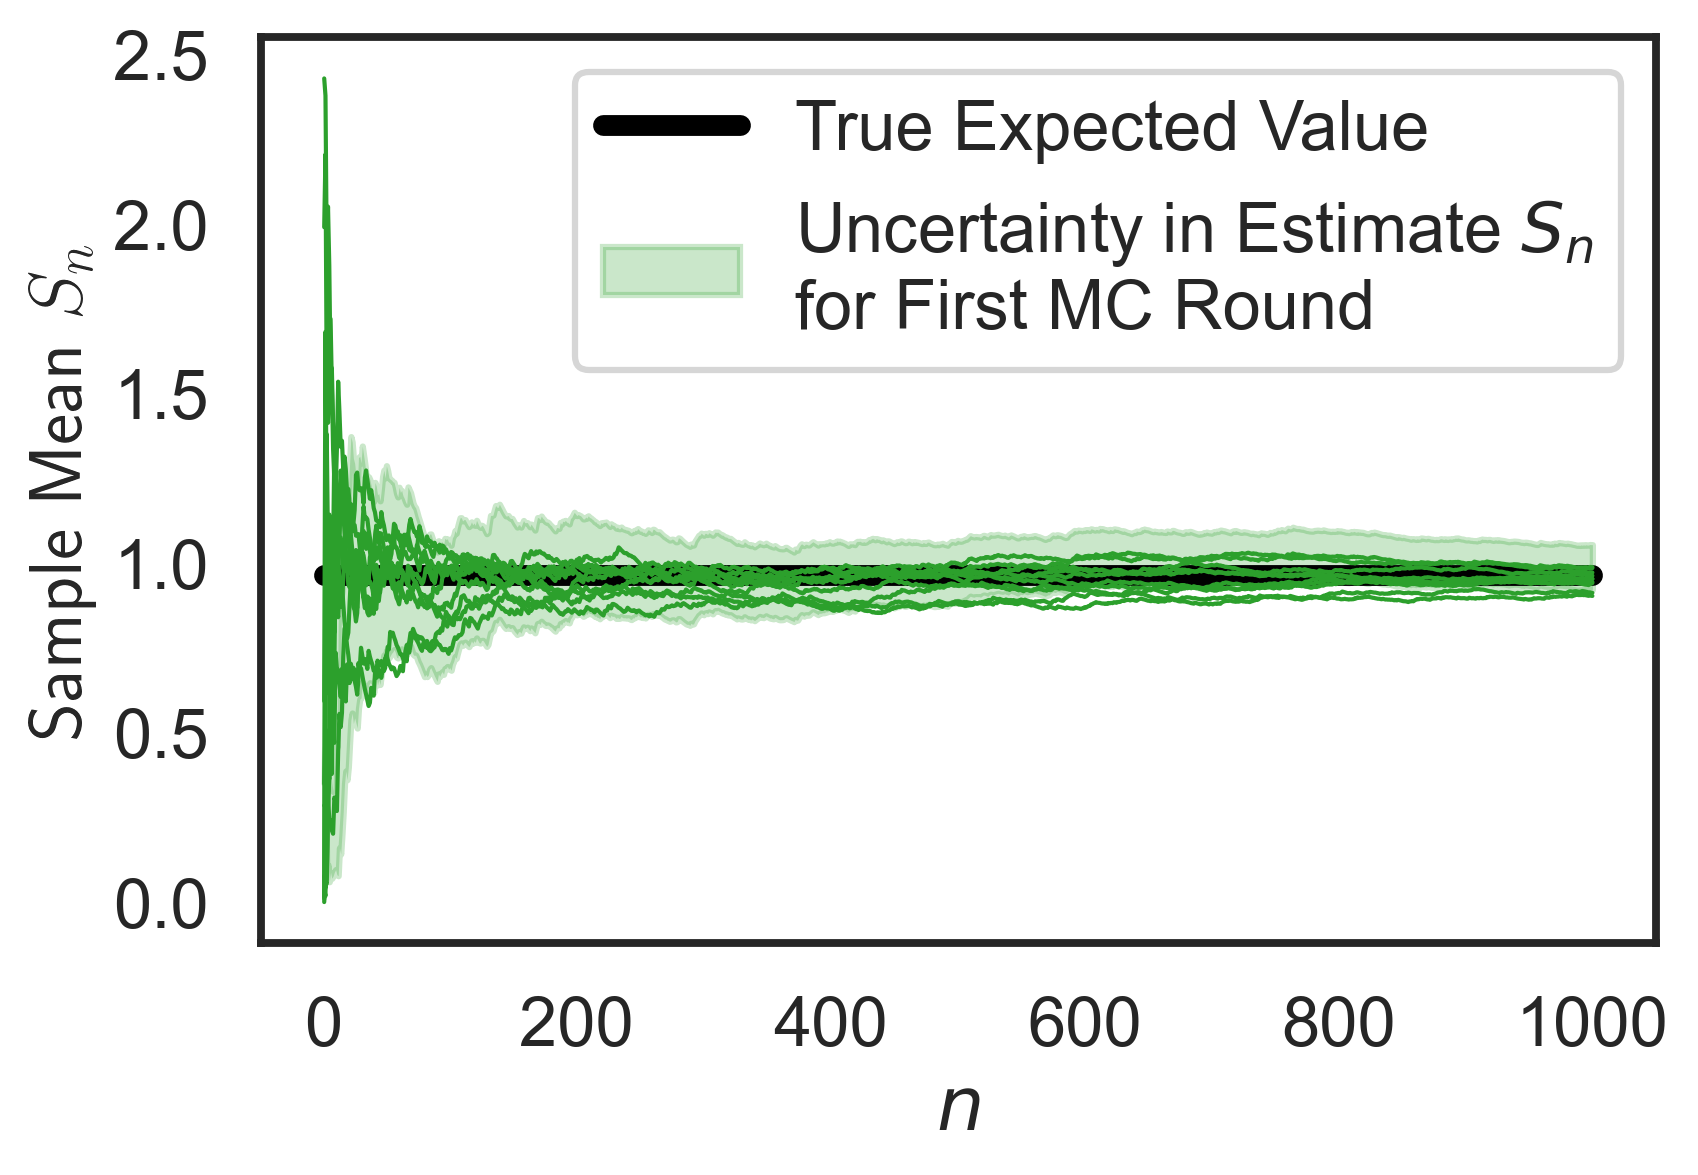

In [39]:
# Number of independent MC runs
num_mc = 10
# Maximum number of samples to take per MC run
max_n  = 1000
# Array holding # of samples
all_ns = np.arange(1, max_n+1)
fig, ax = plt.subplots()
# Plot the true expected value for reference
true_mean, = ax.plot(all_ns, [0.965] * max_n, color='black', linewidth=5.0)
for k in range(num_mc):
    S_n_vals, V_n_vals = get_mc_estimate(max_n = max_n, func = f)
    ax.plot(all_ns, S_n_vals, color = sns.color_palette()[2], lw=1)
    # Give an initial error bar just for the first MC run
    if k == 0:
        # The lower bound
        l = S_n_vals - 2. / np.sqrt(all_ns) * np.sqrt(V_n_vals)
        # The upper bound
        u = S_n_vals + 2. / np.sqrt(all_ns) * np.sqrt(V_n_vals)
        var_rng = ax.fill_between(all_ns, l, u, color = sns.color_palette()[2], alpha = 0.25)

ax.set_xlabel('$n$')
ax.set_ylabel('Sample Mean $S_n$', usetex = True);
err_bar_lab = 'Uncertainty in Estimate $S_n$\nfor First MC Round'
ax.legend([true_mean, var_rng],['True Expected Value',err_bar_lab])

### Questions to Ponder

+ Increase ``max_n`` until you get an answer that is close enough to the correct answer (the black line). Notice how the epistemic error bars shrink around the true value for large $n$. 
+ Reduce ``max_n`` back to 500. Set ``num_mc`` to 10 (or higher). Observe how different MC runs envelop the correct answer. If the epistemic error bars were spot on, only 5 in 100 trajectories would be off. For which $n$ do the epistemic error bars look less accurate (small $n$ or big $n$)? Why do you think that is? Argue using the central limit theorem.